# План -- залог успеха

1. Предобрабатываем и анализируем тексты
    * Строим облако слов в т.ч.
2. Пробуем разные подходы к токенизации
3. Исключаем и не исключаем стоп-слова
4. Да и нет лемматизации//стеммингу
5. Простые векторизации: bag-of-words, CountVectorizer, TfIdfVectorizer
    * Уни-, би- и другие граммы
6. Модели: логрег, SVM
7. Катбуст с текстовыми фичами
8. Аналитика результатов
9. Предложения ребят(ам), как можно улучшить прогноз
    * языковые фичи;
    * аугментации текстов;
    * ...

На любые вопросы по этой домашке постарается ответить Савелий (TG: @Savely_Prokhorov). Не стесняйтесь спрашивать, ему будет приятно помочь.

И помните:

> Не существует глупых вопросов!

Вы можете что-то не знать из того, что нужно для полного выполнения этой домашки -- и это не стыдно. Давайте учиться вместе!

В этом ноутбуке мы выделили **жирным** некоторые рекомендации по тому, что можно улучшить в бейзлайне, чтобы попытаться выбить скор получше.  

Модели давайте сравнивать по $R^2$ ([Вики про коэффициент детерминации](https://en.wikipedia.org/wiki/Coefficient_of_determination))



> **Сохраняйте промежуточные результаты: некоторые алгоритмы отрабатывают довольно долго, обидно будет потерять результаты вычислений; к тому же сохранённые модели (вместе с пайплайнами предобработки, если они отличаются) будет легче состекать**



> А ещё вам могут быть полезны [пайплайны из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Если хорошо приспособите -- будет довольно удобно




In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 76.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=157d79214cc9b0d8f4033b35a25348a50d45dc7be3e4abcee11106ac425b8eff
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec

from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Загрузка данных

In [2]:
df_train = pd.read_csv('../Datasets/vacancies_train.csv')
df_train

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0


In [4]:
df_test = pd.read_csv('../Datasets/vacancies_test.csv', index_col=0) # честный тест -- для него у вас не будет ответов
# а вот на валидацию можете себе, сколько нужно, откусить от трейна
df_test

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
...,...,...,...,...,...,...
5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['Удаленная работа', 'Грамотная речь', 'Пользо..."
5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['Пользователь ПК', 'Розничная торговля', 'Раб..."
5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[]


# Простейший EDA

Для начала посмотрим на распределение таргета в трейне. Видим выбросы совсем низкой зарплаты. **Посмотрите на описание вакансий с выбросами** -- это может помочь объяснить их.

<Axes: xlabel='salary', ylabel='Count'>

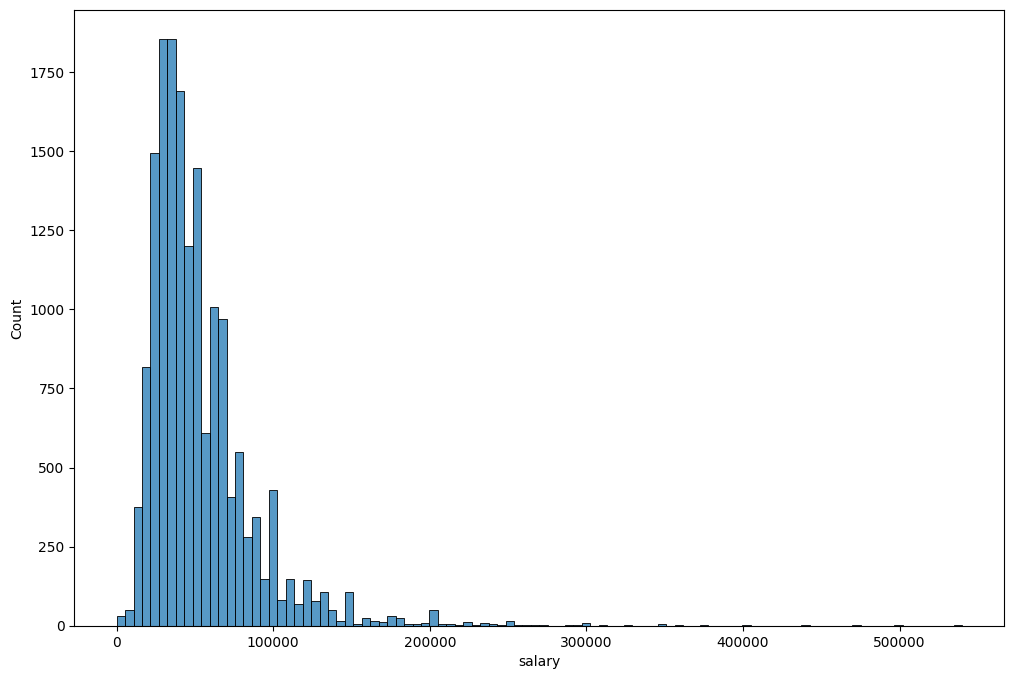

In [5]:
sns.histplot(df_train.salary, bins=100)

In [6]:
# your code here
low_salaries = df_train[df_train['salary'] <= 6000]
for index, row in low_salaries.iterrows():
    print(f"{row['name']}\n{row['salary']}\n{row['description']}\n\n")

Ведущий специалист/Руководитель тендерного отдела
55.0
Компания-поставщик медицинских расходных материалов ищет руководителя тендерного отдела в офис в г. Бердске. Готовы рассматривать специалистов с хорошим опытом в сфере государственных закупок с минимальным опытом руководства. Ставка временная, на период отпуска по уходу за ребенком основного сотрудника. Обязанности:  Оперативное управление сотрудниками, наставничество, обучение; Мониторинг опубликованных аукционов в ЕИС; Подготовка коммерческих предложений; Оформление договоров поставки; Ведение реестра коммерческих предложений, реестра договоров, реестров закупок; Изучение аукционной /конкурсной документации опубликованной Заказчиком, анализ их на соответствие действующему законодательству (ФЗ-44, ФЗ-223); Подготовка и подача заявок для участия в торговых процедурах совместно со специалистами (аукционы, конкурсы, запросы котировок) (ФЗ-44, ФЗ-223); Подача запросов на разъяснение аукционной / конкурсной документации при необходимос

Как видно из описания вакансий с низким значением зп, оплата указана за выход, за одну или за несколько смен или вовсе похожа на мусор

В логарифмированной шкале распределение больше похоже на нормальное (ежели отбросить левый хвост с выбросом). **Подумайте, возможно стоит как-нибудь обработать выбросы или их удалить**

<Axes: xlabel='salary', ylabel='Count'>

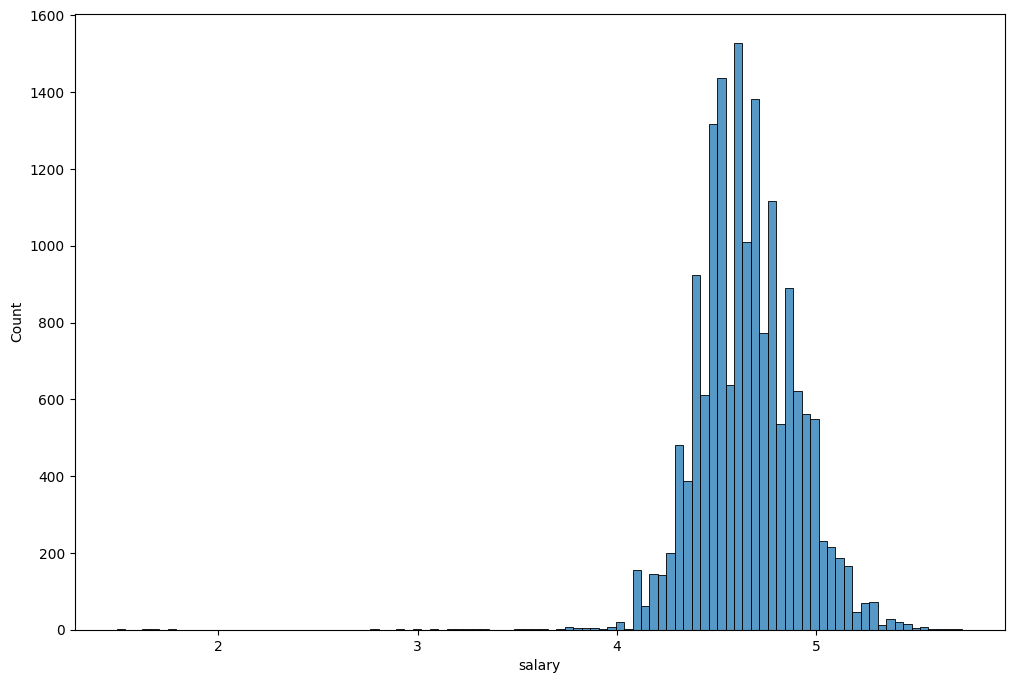

In [7]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [8]:
df_train.name.value_counts()

name
Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: count, Length: 9915, dtype: int64

In [9]:
# your code here

# Определение критерия выброса, например, будем удалять значения зарплат,
# выходящие за пределы трех стандартных отклонений от среднего
mean_salary = df_train['salary'].mean()
std_salary = df_train['salary'].std()
cutoff = 3 * std_salary

# Фильтрация данных для удаления выбросов
filtered_df = df_train.loc[abs(df_train['salary'] - mean_salary) <= cutoff]

# Удалим также значения <= 10000, так как зарплаты там, в основном, указаны за выход или смену
filtered_df = filtered_df.loc[filtered_df['salary'] > 10000]
filtered_df

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0


<Axes: xlabel='salary', ylabel='Count'>

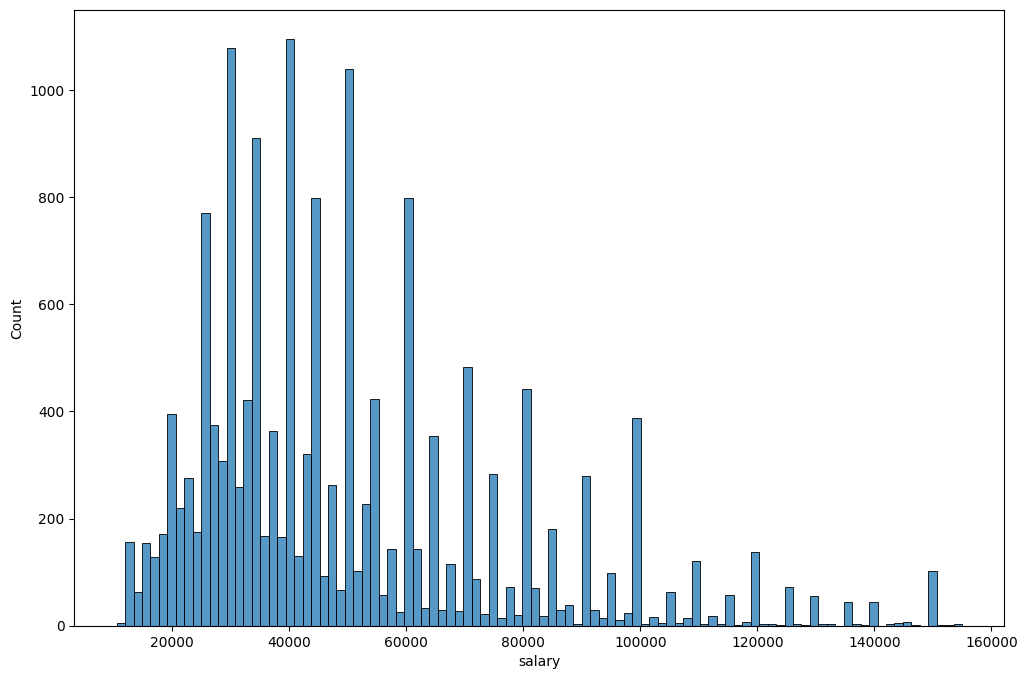

In [10]:
sns.histplot(filtered_df.salary, bins=100)

<Axes: xlabel='salary', ylabel='Count'>

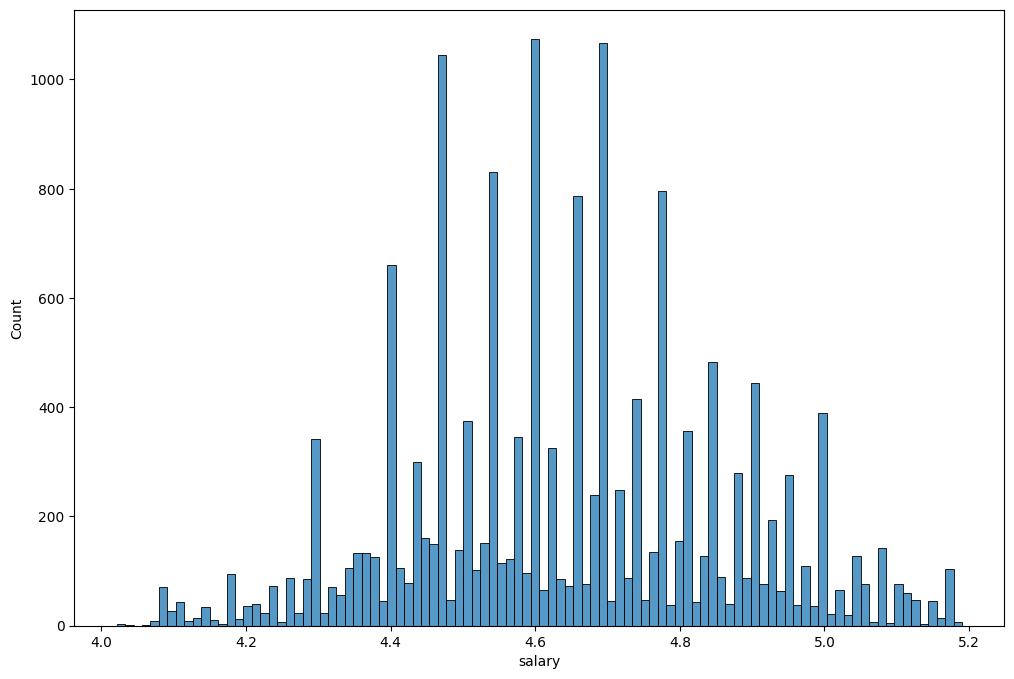

In [11]:
sns.histplot(np.log10(filtered_df.salary + 1), bins=100)

In [12]:
df_train = filtered_df

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного. **Попробуйте визуализировать совместное распределение опыта работы и предлагаемой зп**

<Axes: xlabel='experience', ylabel='Count'>

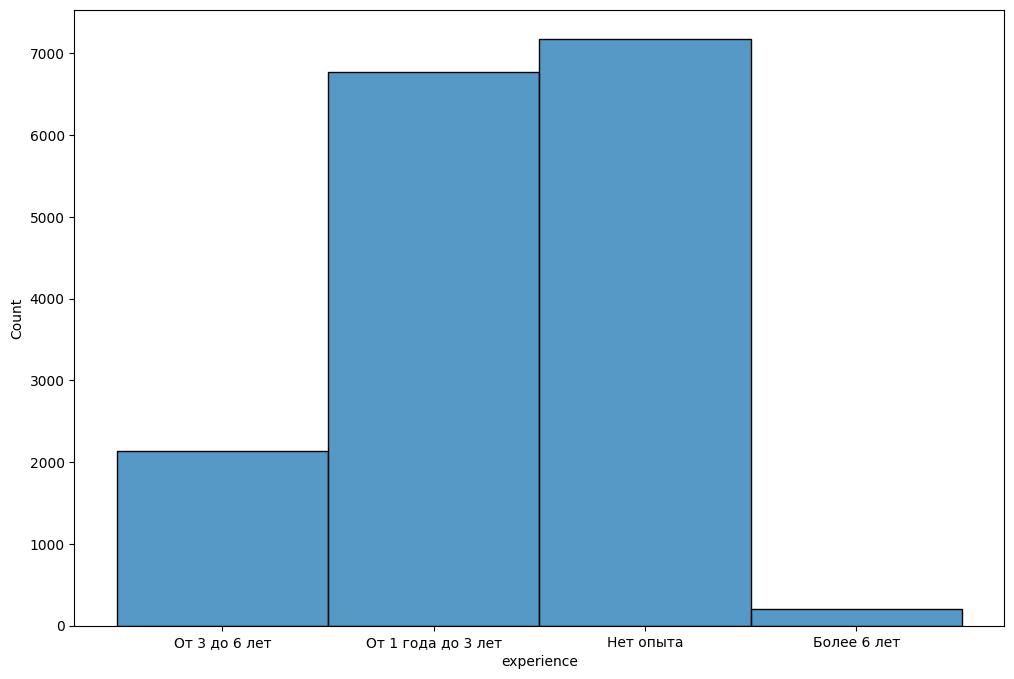

In [13]:
sns.histplot(df_train.experience)

In [14]:
# your code here


Вакансий с графиком занятости, отличной от полной, совсем не много. **Наверное стоит отдельно посмотреть, не отличается ли описание таких вакансий**.

<Axes: xlabel='schedule', ylabel='Count'>

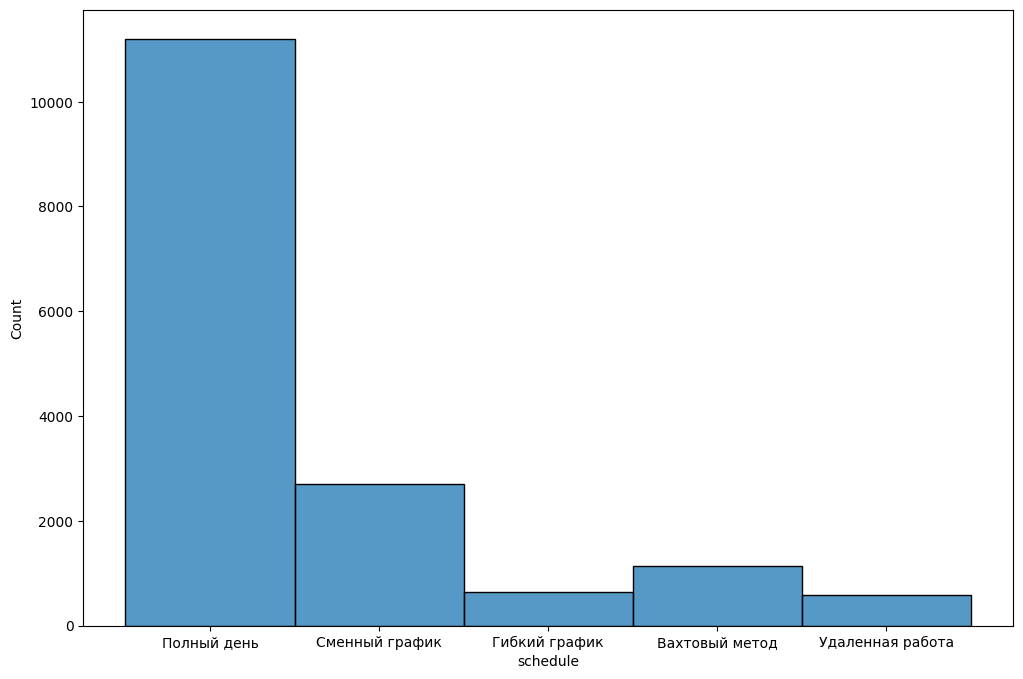

In [15]:
sns.histplot(df_train.schedule)

<Axes: xlabel='employment', ylabel='Count'>

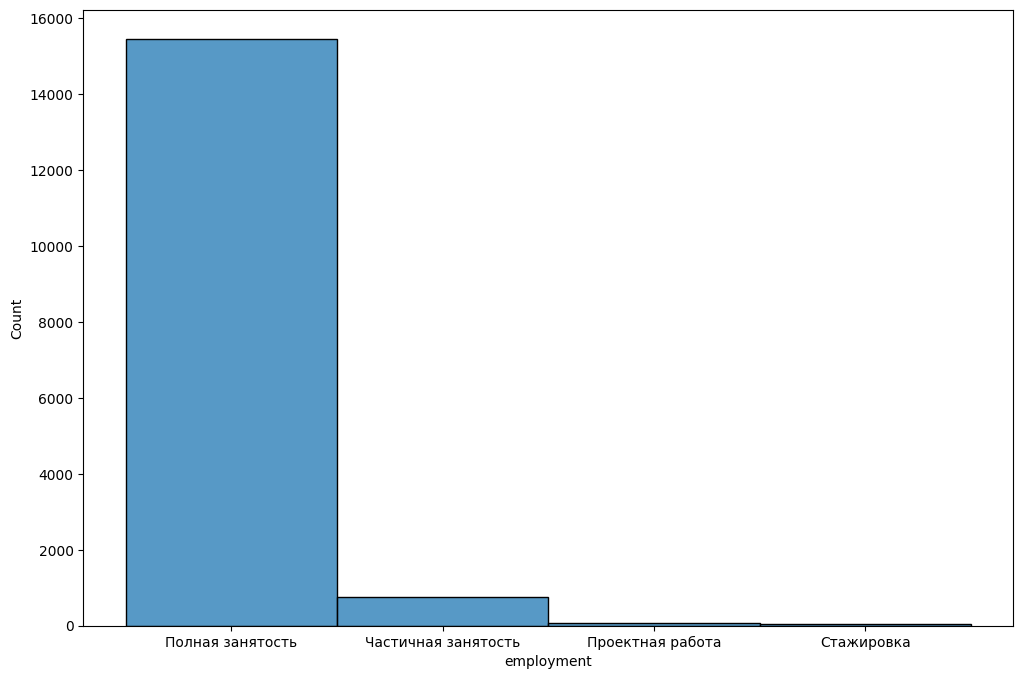

In [16]:
sns.histplot(df_train.employment)

In [17]:
# your code here
descr = df_train.loc[df_train['employment'] != 'Полная занятость']
for _, row in descr.head(5).iterrows():
    print(row['description'] + '\n')

Работа на территории работодателя: р-н Кущевский, с. Полтавченское, ул Трудовая, д. 3, корп. б Обязанности:   Оказывает доврачебную медицинскую помощь, осуществляет забор биологических материалов для лабораторных исследований.   Осуществляет уход за больными в медицинской организации и на дому.   Осуществляет стерилизацию медицинских инструментов, перевязочных средств и предметов ухода за больными.   Ассистирует при проведении врачом лечебно-диагностических манипуляций и малых операций в амбулаторных и стационарных условиях.   Проводит подготовку пациентов к различного рода исследованиям, процедурам, операциям, к амбулаторному приему врача.   Обеспечивает выполнение врачебных назначений.   Осуществляет учет, хранение, использование лекарственных средств и этилового спирта.   Ведет персональный учет, информационную (компьютерную) базу данных состояния здоровья обслуживаемого населения.   Руководит деятельностью младшего медицинского персонала.   Ведет медицинскую документацию.   Проводи

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills`. Логично предположить, что некоторые из них оказывают значимое влияние на предлагаемую зарплату. **Попробуйте проверить эту гипотезу**

In [18]:
from ast import literal_eval
from collections import OrderedDict

In [19]:
skills_count = dict()

for skill_list in df_train.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
skills_count

{'Работа в команде': 2715,
 'Пользователь ПК': 2603,
 'Грамотная речь': 2186,
 'Умение работать в команде': 1128,
 'Активные продажи': 1029,
 'Деловое общение': 835,
 'Навыки продаж': 679,
 'Телефонные переговоры': 621,
 'Ведение переговоров': 590,
 'Организаторские навыки': 566,
 'Деловая переписка': 510,
 'Клиентоориентированность': 501,
 'Обучение и развитие': 483,
 'Поиск и привлечение клиентов': 462,
 'Грамотность': 457,
 'Работа с большим объемом информации': 414,
 'Прямые продажи': 390,
 'Заключение договоров': 341,
 'AutoCAD': 338,
 'Консультирование': 337,
 'Ориентация на результат': 333,
 'Холодные продажи': 333,
 'Управление персоналом': 331,
 '1С: Предприятие 8': 315,
 'Обучение персонала': 314,
 'Работа с людьми': 296,
 'Водительское удостоверение категории B': 284,
 'Навыки межличностного общения': 279,
 'Работа с кассой': 278,
 'Деловая коммуникация': 270,
 'Знание устройства автомобиля': 270,
 'Медицинская документация': 263,
 'Умение работать в коллективе': 261,
 'Англ

In [ ]:
# your code here


**Визуализацию данных из тестового датасета мы предлагаем вам сделать самостоятельно**. Вполне может оказаться так, что они сильно отличаются от трейна.

In [ ]:
# your code here


Постройте облако слов в описаниях вакансий

# Preprocessing

В бейзлайне используем только описание и название вакансии. **Попробуйте в своих моделях учесть и другие признаки**.

In [20]:
df_train_new = pd.DataFrame()
df_train_new['text'] = df_train.name + ' ' + df_train.description
df_train_new

,text
0,Водитель-экспедитор Водитель-экспедитор катего...
1,Кладовщик-комплектовщик/оператор 1С Обязанност...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В...."
3,Администратор магазина (ТЦ Spar) Крупная федер...
4,Мойщик посуды (кулинария) Обязанности: Уборка...
...,...
16624,Полицейский специального полка полиции Обязанн...
16625,Врач стоматолог-ортопед (г. Новосибирск) Обяза...
16626,Фармацевт Условия: официальное оформление по ...
16627,Геодезист (автодороги) Обязанности: своевреме...


In [22]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text) # оставляем только кириллицу
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text) # возвращаем строку
    return text

AttributeError: module 'inspect' has no attribute 'getargspec'

In [ ]:
%time df_train_new['cleaned'] = df_train_new.text.apply(clean_text)
df_train_new

CPU times: user 4min 39s, sys: 715 ms, total: 4min 40s
Wall time: 4min 43s


,text,cleaned
0,Водитель-экспедитор Водитель-экспедитор катего...,водитель экспедитор водитель экспедитор катего...
1,Кладовщик-комплектовщик/оператор 1С Обязанност...,кладовщик комплектовщик оператор обязанность с...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",продавец магазин магнит кировский уса крупный ...
3,Администратор магазина (ТЦ Spar) Крупная федер...,администратор магазин крупный федеральный сеть...
4,Мойщик посуды (кулинария) Обязанности: Уборка...,мойщик посуда кулинария обязанность уборка про...
...,...,...
16624,Полицейский специального полка полиции Обязанн...,полицейский специальный полка полиция обязанно...
16625,Врач стоматолог-ортопед (г. Новосибирск) Обяза...,врач стоматолог ортопед новосибирск обязанност...
16626,Фармацевт Условия: официальное оформление по ...,фармацевт условие официальный оформление графи...
16627,Геодезист (автодороги) Обязанности: своевреме...,геодезист автодорога обязанность своевременный...


In [ ]:
df_test_new = pd.DataFrame()
df_test_new['text'] = df_test.name + ' ' + df_test.description
%time df_test_new['cleaned'] = df_test_new['text'].apply(clean_text)

CPU times: user 1min 35s, sys: 294 ms, total: 1min 36s
Wall time: 1min 37s


In [ ]:
df_test_new

,text,cleaned
0,Главный бухгалтер Обязанности:Осуществление ор...,главный бухгалтер обязанность осуществление ор...
1,Ассистент врача-стоматолога Обязанности: Асси...,ассистент врач стоматолог обязанность ассистир...
2,Менеджер по продажам Если ты: хочешь постро...,менеджер продажа хотеть построить карьера банк...
3,Менеджер Динамично развивающаяся на протяжен...,менеджер динамично развивающийся протяжение го...
4,Администратор хостела ВОЗМОЖНА РАБОТА С ПРОЖИВ...,администратор хостел возможный работа проживан...
...,...,...
5538,Специалист по дистанционному контролю качества...,специалист дистанционный контроль качество янд...
5539,Продавец-консультант Компания ONE SMOKE пригла...,продавец консультант компания приглашать сотру...
5540,Фельдшер скорой медицинской помощи Обязанности...,фельдшер скорый медицинский помощь обязанность...
5541,Продавец-консультант Мечтаешь быть уникальной?...,продавец консультант мечтать уникальный хотеть...


Рекомендуем **попробовать разные сочетания предобработки текста, векторизаторов и моделей в дальнейшем**

In [ ]:
# your code here


# Tf-Idf

In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

In [ ]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(df_train_new.cleaned)
X_train

<16629x76873 sparse matrix of type '<class 'numpy.float64'>'
	with 1746933 stored elements in Compressed Sparse Row format>

In [ ]:
X_test = tfidf.transform(df_test_new.text)
X_test

<5543x76873 sparse matrix of type '<class 'numpy.float64'>'
	with 569038 stored elements in Compressed Sparse Row format>

**Попробуйте OHE, bag-of-words. Используйте разные n-граммы**

In [ ]:
# your code here


# Fit & Predict

Применяем Lasso-регрессию. **Наверняка стоит попробовать более сложные модели и потюнить гиперпараметры** ([хендбук](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov), [Хабр](https://habr.com/ru/companies/otus/articles/754402/))

In [ ]:
lasso = Lasso()
lasso.fit(X_train, df_train.salary)
y_pred = lasso.predict(X_test)

In [ ]:
# your code here


# Catboost
В этом блоке советуем **попытаться запустить catboost**. Для этого в конструкторе класса `CatBoostRegressor` ([документация](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) нужно в параметре `text_features` перечислить текстовые фичи. И ждать магии

In [ ]:
# your code here


## Прочие рекомендации

* **не игонрируйте этап разведочного анализа данных: чем подробнее и глубже вы его сделаете, тем более последовательно вы будете двигаться к лучшему вашему решению**
* **вы можете попробовать какую-то другую токенизацию; возможно в бейзлайне мы не учли что-то важное**
* **разумно попробовать учесть те признаки, что мы проигнорировали в базовом решении (хотя бы банальный OHE-encoding)**


### Дальше в ходе студкемпа мы научимся:
* **пользоваться Word2Vec (обучать с нуля, что не очень используется; или же использовать предобученную и дообучать на текстах задачи)**
* **для перехода к числовым представлениям слов можно попробовать и другие модели: GloVe, fastText, Doc2Vec**
* **или даже расчехлить не слишком тяжеловесные трансформерные**

Улучшите качество модели на вашей валидационной выборке настолько, насколько выйдет

In [ ]:
# your code here


# Анализ результатов

Проведите аналитику результатов. Сравните модели и способы предобработки. Укажите, каким образом удалось добиться наилучшего качества. Перечислите достоинства и недостатки для прода простых (a la OHE) и сложных (catboost с подобранными гиперпараметрами) моделей. Если время на эксперименты всё, то напишите свои мысли, как можно было бы улучшить прогноз